# ARIMA + NN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ARIMA y ETS
import pmdarima as pm

# PyTorch para la NN
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Para ACF/PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Implementación manual del test Diebold-Mariano (DM)
from scipy.stats import norm

In [ ]:

def dm_test(e1, e2, h=1, crit="MSE"):
    """
    e1, e2: vectores de error (por ejemplo, (y - yhat))
    crit: "MSE" => d_t = e1^2 - e2^2; "MAE" => d_t = |e1| - |e2|
    Retorna: (DM_stat, p_value)
    """
    e1 = np.array(e1)
    e2 = np.array(e2)
    if crit == "MSE":
        d = e1**2 - e2**2
    elif crit == "MAE":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")
    d_bar = np.mean(d)
    var_d = np.var(d, ddof=1)  # varianza sin corrección por autocorrelación
    n = len(d)
    DM_stat = d_bar / np.sqrt(var_d/n)
    p_value = 2*(1 - norm.cdf(abs(DM_stat)))
    return DM_stat, p_value

###############################################################################
# 1) CARGA DE DATOS: Usamos CSVs separados para train y test
###############################################################################
def load_univariate_series(csv_path, column_name=None, plot_series=False):
    df = pd.read_csv(csv_path, parse_dates=['Date'])
    df.sort_values('Date', inplace=True)
    if column_name is None:
        candidates = [c for c in df.columns if c != 'Date']
        column_name = candidates[0]
    series = df[column_name].values.astype(float)
    if plot_series:
        plt.figure()
        plt.plot(series, label=column_name)
        plt.title(f"Serie: {column_name}")
        plt.legend()
        plt.show()
    return series, column_name

###############################################################################
# 2) CREACIÓN DE LAGS Y DEFINICIÓN DE LA NN (MLP)
###############################################################################
def create_lag_features(series, lag=5):
    dataX, dataY = [], []
    for i in range(lag, len(series)):
        dataX.append(series[i-lag:i])
        dataY.append(series[i])
    return np.array(dataX), np.array(dataY)

class ResidualMLP(nn.Module):
    def __init__(self, input_size, hidden_size=8):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        return out

###############################################################################
# 3) PIPELINE HÍBRIDO ARIMA + NN (basado en Zhang, 2003)
###############################################################################
def hybrid_arima_nn_improved(train_series, test_series, lag=5, epochs=150, lr=1e-4, hidden_size=8, grad_clip=5.0, plot=True):
    # --- Ajuste ARIMA en train
    arima_model = pm.auto_arima(
        train_series,
        start_p=0, start_q=0,
        max_p=5, max_q=5, max_d=2,
        seasonal=False,
        trace=False,
        error_action='ignore',
        suppress_warnings=True
    )
    arima_model.fit(train_series)
    arima_pred_train = arima_model.predict_in_sample()
    residuals_train = train_series - arima_pred_train

    # --- Normalización para la serie y los residuos
    scaler_y = MinMaxScaler(feature_range=(-1,1))
    train_y_2d = train_series.reshape(-1,1)
    scaler_y.fit(train_y_2d)
    train_series_scaled = scaler_y.transform(train_y_2d).flatten()

    scaler_resid = MinMaxScaler(feature_range=(-1,1))
    resid_2d = residuals_train.reshape(-1,1)
    scaler_resid.fit(resid_2d)
    residuals_norm = scaler_resid.transform(resid_2d).flatten()

    # --- Creación de dataset para la NN
    X_train_lag, _ = create_lag_features(train_series_scaled, lag=lag)
    residuals_for_nn = residuals_norm[lag:]
    X_train_torch = torch.tensor(X_train_lag, dtype=torch.float32)
    Y_train_torch = torch.tensor(residuals_for_nn, dtype=torch.float32).view(-1,1)

    net = ResidualMLP(input_size=lag, hidden_size=hidden_size)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    net.train()
    batch_size = 32
    idx_full = np.arange(X_train_torch.shape[0])
    for ep in range(epochs):
        np.random.shuffle(idx_full)
        for i in range(0, len(idx_full), batch_size):
            b_idx = idx_full[i:i+batch_size]
            Xb = X_train_torch[b_idx]
            Yb = Y_train_torch[b_idx]
            optimizer.zero_grad()
            out = net(Xb)
            loss = criterion(out, Yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
            optimizer.step()
        if (ep+1) % 10 == 0:
            print(f"[Epoch {ep+1}/{epochs}] NN MSE(loss) = {loss.item():.4f}")

    # --- Predicción en test: ARIMA
    ntest = len(test_series)
    arima_pred_test = arima_model.predict(n_periods=ntest)

    # --- Predicción NN sobre residuos en test
    full_series = np.concatenate([train_series, test_series])
    full_series_scaled = scaler_y.transform(full_series.reshape(-1,1)).flatten()
    X_full_lag, _ = create_lag_features(full_series_scaled, lag=lag)
    X_test_lag = X_full_lag[-ntest:]
    net.eval()
    with torch.no_grad():
        X_test_torch = torch.tensor(X_test_lag, dtype=torch.float32)
        nn_resid_test_norm = net(X_test_torch).numpy().flatten()
        nn_resid_test = scaler_resid.inverse_transform(nn_resid_test_norm.reshape(-1,1)).flatten()

    hybrid_pred = arima_pred_test + nn_resid_test

    # --- Evaluación: Métricas
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred)/(y_true+1e-9)))*100

    rmse_arima = np.sqrt(mean_squared_error(test_series, arima_pred_test))
    rmse_hybrid = np.sqrt(mean_squared_error(test_series, hybrid_pred))
    mae_arima = mean_absolute_error(test_series, arima_pred_test)
    mae_hybrid = mean_absolute_error(test_series, hybrid_pred)
    mape_arima = mape(test_series, arima_pred_test)
    mape_hybrid = mape(test_series, hybrid_pred)


    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(len(full_series)), full_series, label='Serie Real', alpha=0.6)
        plt.axvline(len(train_series), color='k', linestyle='--', label='Train/Test Split')
        test_index = np.arange(len(train_series), len(full_series))
        plt.plot(test_index, arima_pred_test, 'r-', label='ARIMA')
        plt.plot(test_index, hybrid_pred, 'g-', label='Híbrido')
        plt.title("Comparación de Modelos: ARIMA vs. Híbrido vs. Baselines")
        plt.legend()
        plt.show()

        print("\n=== MÉTRICAS EN TEST ===")
        print("           RMSE      MAE      MAPE")
        print(f"ARIMA:   {rmse_arima:.4f}  {mae_arima:.4f}  {mape_arima:.2f}%")
        print(f"Híbrido: {rmse_hybrid:.4f}  {mae_hybrid:.4f}  {mape_hybrid:.2f}%")

    # --- Análisis de errores finales (ruido blanco)
    final_errors = test_series - hybrid_pred
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plot_acf(final_errors, lags=min(20, int(len(final_errors)/2)-1), zero=False, ax=plt.gca(), title="ACF errores (Híbrido)")
    plt.subplot(1,2,2)
    plot_pacf(final_errors, lags=min(20, int(len(final_errors)/2)-1), zero=False, method='ywm', ax=plt.gca(), title="PACF errores (Híbrido)")
    plt.tight_layout()
    plt.show()

    # --- Diebold-Mariano test: Compara ARIMA vs. Híbrido (utilizando error al cuadrado)
    e_arima = test_series - arima_pred_test
    e_hybrid = test_series - hybrid_pred
    DM_stat, p_val = dm_test(e_arima, e_hybrid, h=1, crit="MSE")
    print("\n=== Diebold-Mariano Test (ARIMA vs. Híbrido) ===")
    print(f"DM statistic = {DM_stat:.4f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print("La diferencia es estadísticamente significativa (p < 0.05).")
    else:
        print("La diferencia NO es estadísticamente significativa (p >= 0.05).")

    return {
        'arima_pred_test': arima_pred_test,
        'hybrid_pred': hybrid_pred,
        'test_series': test_series,
        'rmse_arima': rmse_arima,
        'rmse_hybrid': rmse_hybrid,
        'mae_arima': mae_arima,
        'mae_hybrid': mae_hybrid,
        'mape_arima': mape_arima,
        'mape_hybrid': mape_hybrid,
        'dm_test': (DM_stat, p_val)
    }

###############################################################################
# 5) SCRIPT PRINCIPAL
###############################################################################


Serie de entrenamiento: 'Pinar del Rio', tamaño: 387
Serie de prueba: 'Pinar del Rio', tamaño: 55


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pytho

[Epoch 10/150] NN MSE(loss) = 0.2443
[Epoch 20/150] NN MSE(loss) = 0.1883
[Epoch 30/150] NN MSE(loss) = 0.1441
[Epoch 40/150] NN MSE(loss) = 0.0653
[Epoch 50/150] NN MSE(loss) = 0.1106
[Epoch 60/150] NN MSE(loss) = 0.1005
[Epoch 70/150] NN MSE(loss) = 0.0468
[Epoch 80/150] NN MSE(loss) = 0.0210
[Epoch 90/150] NN MSE(loss) = 0.1060
[Epoch 100/150] NN MSE(loss) = 0.0310
[Epoch 110/150] NN MSE(loss) = 0.0560
[Epoch 120/150] NN MSE(loss) = 0.0896
[Epoch 130/150] NN MSE(loss) = 0.0510
[Epoch 140/150] NN MSE(loss) = 0.0209
[Epoch 150/150] NN MSE(loss) = 0.0127


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


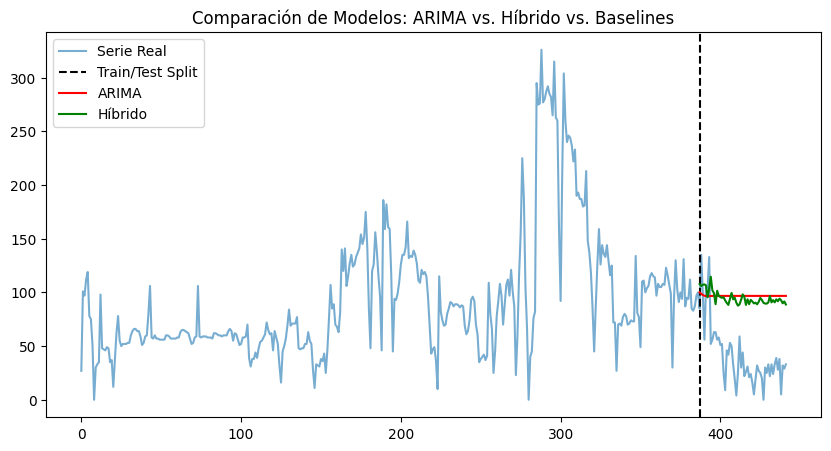


=== MÉTRICAS EN TEST ===
           RMSE      MAE      MAPE
ARIMA:   62.4947  58.6962  175932381456.41%
Híbrido: 59.0806  55.6932  164117099658.01%


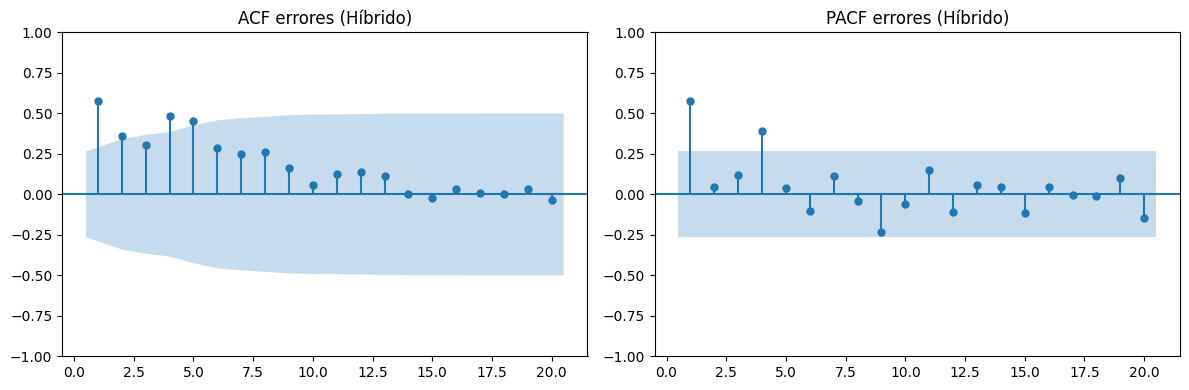

NameError: name 'norm' is not defined

In [10]:
    # Rutas a los CSVs
train_csv = "Anexos_7/training/total_incomes_augmented_training_data.csv"
test_csv = "Anexos_7/test/total_incomes_test_data.csv"

train_series, col_train = load_univariate_series(train_csv, column_name=None, plot_series=False)
test_series, col_test = load_univariate_series(test_csv, column_name=None, plot_series=False)
print(f"Serie de entrenamiento: '{col_train}', tamaño: {len(train_series)}")
print(f"Serie de prueba: '{col_test}', tamaño: {len(test_series)}")

results = hybrid_arima_nn_improved(
    train_series,
    test_series,
    lag=5,
    epochs=150,
    lr=1e-4,
    hidden_size=8,
    plot=True,
    grad_clip=5.0
)